In [1]:
!curl -O http://mattmahoney.net/dc/text8.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29.8M  100 29.8M    0     0  11.5M      0  0:00:02  0:00:02 --:--:-- 11.5M


In [2]:
!unzip text8.zip

Archive:  text8.zip
  inflating: text8                   


In [3]:
import re
from collections import Counter
from tqdm.notebook import tqdm
import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [4]:
tokens = []

In [5]:
tokenize = lambda item: item.lower().split()

In [6]:
%%time
with open('text8', 'r') as file:
    for line in file:
        tokens += tokenize(line)

CPU times: user 1.43 s, sys: 877 ms, total: 2.3 s
Wall time: 3.28 s


In [7]:
words_freq = Counter(tokens)
words_freq = Counter({k: c for k, c in words_freq.items() if c >= 20}).most_common(200_000)

vocabulary = [key for key, _ in words_freq]
unk_token = '<UNK>'
vocabulary.append(unk_token)

In [8]:
ind_to_word = dict(enumerate(vocabulary))
word_to_ind = {value: key for key, value in ind_to_word.items()}

In [9]:
class W2VDataset(Dataset):
    def __init__(self, tokens: list, word_to_ind: dict, unk_token: str, window_size: int = 4):
        self.tokens = tokens
        self.vocab = word_to_ind
        self.unk_token = unk_token
        assert not window_size % 2
        self.window_size = window_size

    def __getitem__(self, item):
        center_index = item + self.window_size // 2
        center_word = self.vocab.get(self.tokens[center_index], self.vocab[self.unk_token])

        context_words = [
            self.vocab.get(self.tokens[i], self.vocab[self.unk_token])
            for i in range(item, item + self.window_size + 1)
            if i != center_index
        ]

        return {
            'word': torch.tensor(center_word, dtype=torch.long),
            'context': torch.tensor(context_words, dtype=torch.long)
            }

    def __len__(self):
        return len(self.tokens) - self.window_size

In [10]:
dataset = W2VDataset(tokens, word_to_ind, unk_token)
loader = DataLoader(dataset, batch_size=224, num_workers=2, shuffle=True)

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [12]:
for batch in loader:
    print(batch['word'].shape, batch['context'].shape)
    break

torch.Size([224]) torch.Size([224, 4])


In [13]:
len(loader), len(dataset)

(75917, 17005203)

In [14]:
class W2VModel(nn.Module):
    def __init__(self, vocab_size, emb_dim):
        super(W2VModel, self).__init__()
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim

        self.emb = nn.Embedding(self.vocab_size, self.emb_dim)
        self.decoder = nn.Linear(self.emb_dim, self.vocab_size)

        self.init_emb()

    def forward(self, x):
        x = self.emb(x)
        return self.decoder(x)

    def init_emb(self):
        """
        init the weight as original word2vec do.
        """
        initrange = 0.5 / self.emb_dim
        self.emb.weight.data.uniform_(-initrange, initrange)
        self.decoder.weight.data.uniform_(0, 0)

In [15]:
def create_labels(context_index: torch.Tensor, vocab_size: int):
    batch_size = context_index.size(0)
    labels = torch.zeros(batch_size, vocab_size)
    for i in range(batch_size):
        labels[i, context_index[i]] = 1
    return labels

In [16]:
def train(
    epoch: int,
    model: nn.Module,
    train_loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: str
):
    epoch_loss = 0
    for batch in tqdm(train_loader, total=len(train_loader)):
        center, context = batch['word'].to(device), batch['context'].to(device)
        labels = create_labels(context, model.vocab_size).to(device)

        optimizer.zero_grad()
        loss = criterion(model(center), labels)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    print(f'Epoch: {epoch}, Loss: {epoch_loss / len(train_loader)}')
    return epoch_loss / len(train_loader)

In [17]:
model = W2VModel(len(word_to_ind), 200).to(device)

In [18]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []


for epoch in range(2):
    train_loss = train(epoch, model, loader, criterion, optimizer, device)

    train_losses.append(train_loss)

  0%|          | 0/75917 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.0030066878291172086


  0%|          | 0/75917 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.0007608064727032514


In [19]:
torch.save(model, 'w2v_model.torch')

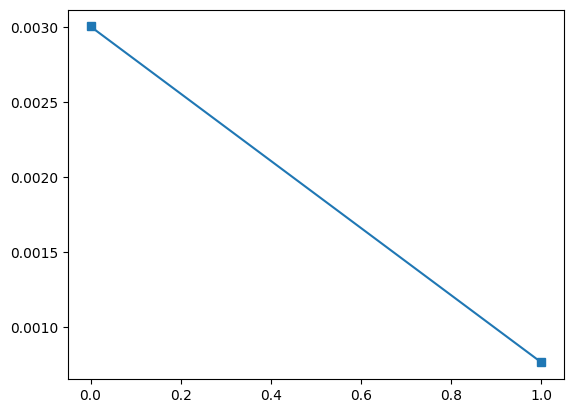

In [20]:
import matplotlib.pyplot as plt
plt.plot(train_losses, marker='s')

In [21]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import pandas as pd

In [22]:
result = dict()
for key, value in tqdm(word_to_ind.items()):
    preds = model.emb.weight[value]
    result[key] = preds.cpu().detach().numpy()

  0%|          | 0/31893 [00:00<?, ?it/s]

In [23]:
word = 'gun'

In [24]:
df = dict()
for key, value in tqdm(result.items()):
    distance = cosine_similarity(result[word].reshape(1, -1), value.reshape(1, -1))[0][0]
    df[key] = distance

  0%|          | 0/31893 [00:00<?, ?it/s]

In [25]:
pd.DataFrame(df, index=[0]).T.reset_index().sort_values(0, ascending=False).head(15)

,index,0
1746,gun,1.000000
2699,guns,0.747512
16325,submachine,0.713326
16446,gatling,0.701399
4115,rifle,0.694233
2267,weapon,0.669182
3975,assault,0.668035
9136,pistol,0.667657
3543,tank,0.662416
5618,armour,0.640750
